<h1>Pronóstico Concreto - Version 2</h1>

In [11]:
# Parte 1 - Preprocesado de los datos

# Importación de las librerías
import numpy as np
import pandas as pd
from keras.models import load_model
#import modulo_conn_sql as mcq
import datetime 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from io import BytesIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pickle import dump
from pickle import load

In [12]:
#Metodos auxiliares
"""
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor



def obtenerDataTrain(pais, inicio, fin):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute("{CALL SCAC_AP4_Serie_VolumenDiario (?,?,?)}" , (pais, inicio, fin) )
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

def obtenerDataAux_Test(pais, dias):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute("{CALL SCAC_AP4_Serie_VolumenDiario_AuxFecha (?,?)}" , (pais, dias) )
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)
"""

def plot_time_series(dates, values, title, x_label, y_label):
    """
    dates: must be a datetime series for the x axis
    values: the y axis values to plot
    title: string that goes above the plot
    x_label: string that goes on the x-axis
    y_label: string that goes on the y-axis
    """

    years_locator = mdates.YearLocator()
    years_format = mdates.DateFormatter('%Y')
 

    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)

    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    

    sns.lineplot(x=dates, y=values, ci=None)

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.xlabel(x_label, fontsize='16')
    plt.ylabel(y_label, fontsize='16')
    plt.title(title, fontsize='18')

    plt.show()

In [106]:
#Parametros
pais = 'Colombia'      
inicioHistoria = datetime.datetime(2020, 7, 1) #'2013-05-01'
finHistoria = datetime.datetime.today() #fecha actual
fecha_split = '2021-07-01'

#Memoria corto plazo
timesteps = 29
#numero de neuronas
un = 200
#coeficiente de olvido
do = 0.1
#numero de ciclos
ep = 500

In [107]:
# Importar el dataset de entrenamiento
#dataset = obtenerDataTrain( pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") )

dataset = pd.read_excel("../datos/" + pais +"/" + pais + ".xlsx")
dataset['Fecha'] = pd.to_datetime(dataset['Fecha'])
dataset = dataset[ dataset['Fecha'] >= inicioHistoria]

dataset_array = dataset.iloc[:, 2:8].values

#Defino el dataset de entrenamiento y el de test
dataset_train = dataset[ dataset['Fecha'] < fecha_split]
training_set  = dataset_train.iloc[:, 2:8].values

dataset_test = dataset[ dataset['Fecha'] >= fecha_split ]
test_set  = dataset_test.iloc[:, 2:8].values

# Escalado de características
sc = MinMaxScaler(feature_range = (0, 1))
dataset_array_scaled = sc.fit_transform(dataset_array)
training_set_scaled = sc.transform(training_set)
test_set_scaled = sc.transform(test_set)

# save the scaler
dump(sc, open("../datos/" + pais + "/" + pais +'.pkl', 'wb'))

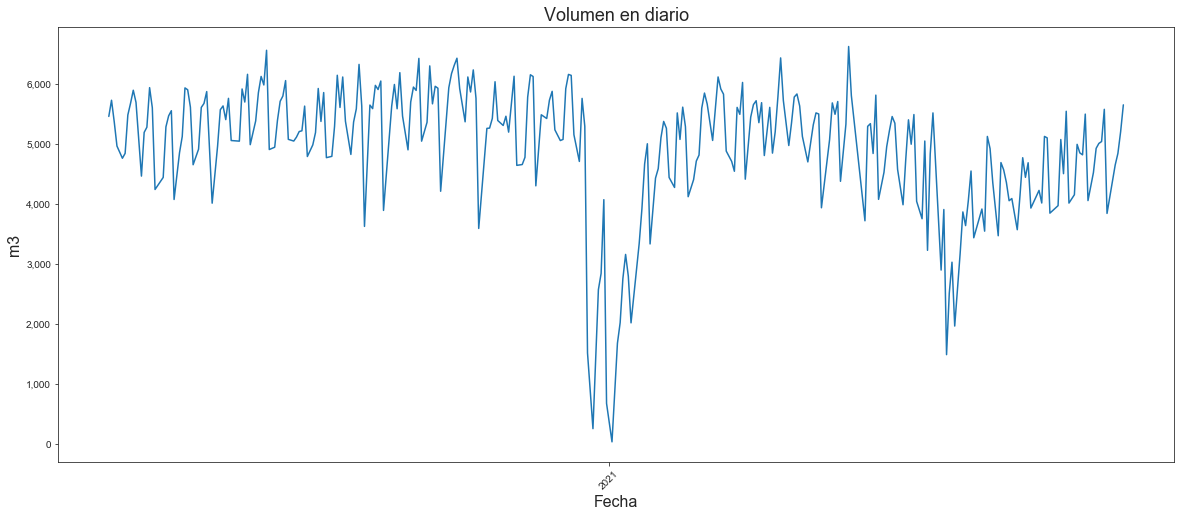

In [108]:
#ds1 = dataset[(dataset['Fecha']>= '2020-01-20') & (dataset['Fecha']<= '2021-05-30')]
ds1= dataset
plot_time_series(ds1['Fecha'], ds1['Vol'], 'Volumen en diario', 'Fecha', 'm3')

In [92]:
d = dataset
calendario = pd.read_excel("../datos/Calendario.xlsx")
calendario['Fecha de entrega'] = pd.to_datetime(calendario['Fecha de entrega'])
d = pd.merge( calendario[(calendario['Fecha de entrega'] < '2021-06-07') & (calendario['Fecha de entrega'] > '2020-01-01')]['Fecha de entrega'], d[['Fecha', 'Vol']], how='left', left_on=['Fecha de entrega'], right_on='Fecha').drop(['Fecha'], axis=1)
#d = pd.merge( calendario[(calendario['Fecha de entrega'] < '2021-06-15')]['Fecha de entrega'], d[['Fecha', 'Vol']], how='left', left_on=['Fecha de entrega'], right_on='Fecha').drop(['Fecha'], axis=1)
d = d.set_index(['Fecha de entrega'])
d = d.asfreq('d')
d['Vol'] = d['Vol'].fillna(method='bfill')


In [32]:
results = seasonal_decompose(d['Vol'])
results.observed.plot(figsize=(12,2))

ValueError: This function does not handle missing values

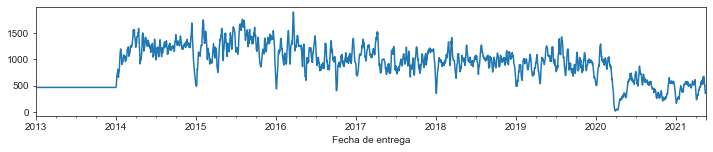

In [248]:
results.trend.plot(figsize=(12,2))

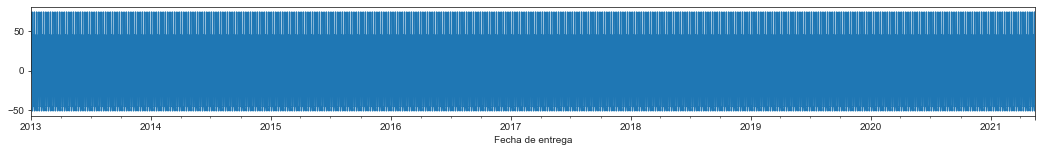

In [249]:
results.seasonal.plot(figsize=(18,2))

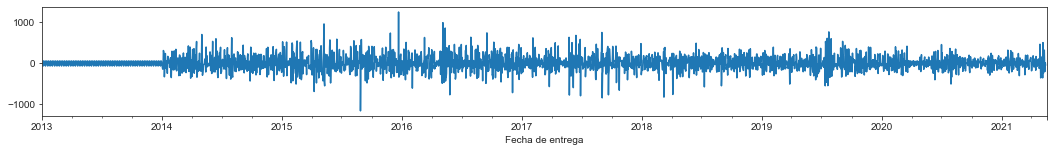

In [250]:
results.resid.plot(figsize=(18,2))

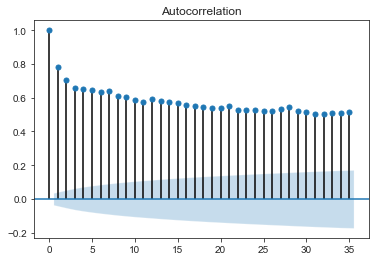

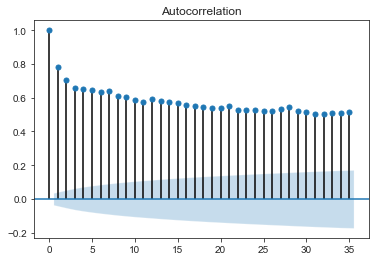

In [251]:
plot_acf(d['Vol'])

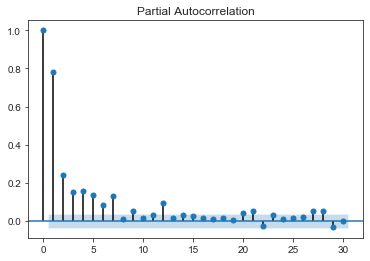

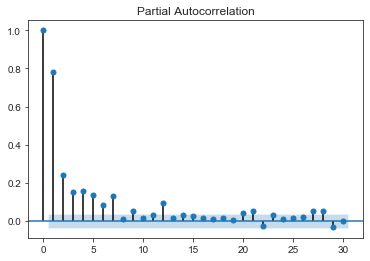

In [252]:
plot_pacf(d['Vol'], lags=30)

In [109]:
#ESTRUCTURA DE LA RED NEURONAL RECURRENTE

#defino un array por cada variable predictora
X_train = []
X_train_material = []
X_train_DiaSemana = []
X_train_SemanaRelativa = []
X_train_SemanaMes = []
X_train_Mes = []
X_train_Year = []

y_train = []

for i in range(timesteps, len(training_set)):
    #columna 0 -> Cantidad Material
    X_train_material.append( training_set_scaled[i-timesteps:i, 0])
    
    #columna 1 -> DiaSemana
    X_train_DiaSemana.append( training_set_scaled[i-timesteps:i, 1])
    
    #columna 2 -> Mes
    X_train_Mes.append( training_set_scaled[i-timesteps:i, 2])
    
    #columna 3 -> SemanaRelativa
    X_train_SemanaRelativa.append( training_set_scaled[i-timesteps:i, 3])

    #columna 4 -> SemanaMes
    X_train_SemanaMes.append( training_set_scaled[i-timesteps:i, 4])
    
    #columna 5 -> Year
    X_train_Year.append( training_set_scaled[i-timesteps:i, 5])
    
    y_train.append(training_set_scaled[i, 0])

#se convierten los array en objetos numpy    
X_train_material = np.array( X_train_material)
X_train_DiaSemana =  np.array(X_train_DiaSemana )
X_train_SemanaRelativa = np.array( X_train_SemanaRelativa)
X_train_SemanaMes = np.array(X_train_SemanaMes )
X_train_Mes = np.array(X_train_Mes )
X_train_Year = np.array( X_train_Year)
y_train = np.array(y_train)

#Se agrega una nueva dimension a las variables
X_train_material = np.reshape(X_train_material, (X_train_material.shape[0], X_train_material.shape[1], 1 ))
X_train_DiaSemana = np.reshape(X_train_DiaSemana, (X_train_DiaSemana.shape[0], X_train_DiaSemana.shape[1], 1 ))
X_train_SemanaRelativa = np.reshape(X_train_SemanaRelativa, (X_train_SemanaRelativa.shape[0], X_train_SemanaRelativa.shape[1], 1 ))
X_train_SemanaMes = np.reshape(X_train_SemanaMes, (X_train_SemanaMes.shape[0], X_train_SemanaMes.shape[1], 1 ))
X_train_Mes = np.reshape(X_train_Mes, (X_train_Mes.shape[0], X_train_Mes.shape[1], 1 ))
X_train_Year = np.reshape(X_train_Year, (X_train_Year.shape[0], X_train_Year.shape[1], 1 ))

#se crea el la estructura de datos que se le va a pasar al regresor
X_train = np.append(X_train_material, (X_train_DiaSemana), axis = 2 )
X_train = np.append(X_train, (X_train_Mes), axis = 2 )
X_train = np.append(X_train, (X_train_SemanaRelativa), axis = 2 )
X_train = np.append(X_train, (X_train_SemanaMes), axis = 2 )
X_train = np.append(X_train, (X_train_Year), axis = 2 )

#inicializacion del regresor
regressor = Sequential()

#añadir la primera capa de LSTM y la regularización por Dropout
#regressor.add(LSTM(units= un, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
#regressor.add(Dropout(do))

regressor.add(LSTM(units=un, input_shape=(X_train.shape[1], X_train.shape[2])))

"""
#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir penultima capa
regressor.add(LSTM(units=un))
regressor.add(Dropout(do))
"""
#añadir capa de salida
regressor.add(Dense(units=1))

#compilar la RNR
regressor.compile(optimizer = 'adam', loss='mean_squared_error')

In [110]:
#ajustar la RNR al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs=ep, batch_size = 512)

Epoch 1/500
266/266 [==============================] - 1s 4ms/step - loss: 0.5998
Epoch 2/500
266/266 [==============================] - 0s 430us/step - loss: 0.2785
Epoch 3/500
266/266 [==============================] - 0s 437us/step - loss: 0.0855
Epoch 4/500
266/266 [==============================] - 0s 448us/step - loss: 0.0397
Epoch 5/500
266/266 [==============================] - 0s 443us/step - loss: 0.1220
Epoch 6/500
266/266 [==============================] - 0s 438us/step - loss: 0.1034
Epoch 7/500
266/266 [==============================] - 0s 414us/step - loss: 0.0568
Epoch 8/500
266/266 [==============================] - 0s 416us/step - loss: 0.0335
Epoch 9/500
266/266 [==============================] - 0s 402us/step - loss: 0.0312
Epoch 10/500
266/266 [==============================] - 0s 410us/step - loss: 0.0380
Epoch 11/500
266/266 [==============================] - 0s 420us/step - loss: 0.0458
Epoch 12/500
266/266 [==============================] - 0s 430us/step - loss

Epoch 98/500
266/266 [==============================] - 0s 452us/step - loss: 0.0137
Epoch 99/500
266/266 [==============================] - 0s 445us/step - loss: 0.0137
Epoch 100/500
266/266 [==============================] - 0s 447us/step - loss: 0.0136
Epoch 101/500
266/266 [==============================] - 0s 443us/step - loss: 0.0136
Epoch 102/500
266/266 [==============================] - 0s 448us/step - loss: 0.0135
Epoch 103/500
266/266 [==============================] - 0s 472us/step - loss: 0.0135
Epoch 104/500
266/266 [==============================] - 0s 457us/step - loss: 0.0135
Epoch 105/500
266/266 [==============================] - 0s 438us/step - loss: 0.0134
Epoch 106/500
266/266 [==============================] - 0s 440us/step - loss: 0.0134
Epoch 107/500
266/266 [==============================] - 0s 436us/step - loss: 0.0134
Epoch 108/500
266/266 [==============================] - 0s 434us/step - loss: 0.0133
Epoch 109/500
266/266 [==============================] -

Epoch 194/500
266/266 [==============================] - 0s 487us/step - loss: 0.0124
Epoch 195/500
266/266 [==============================] - 0s 488us/step - loss: 0.0117
Epoch 196/500
266/266 [==============================] - 0s 448us/step - loss: 0.0122
Epoch 197/500
266/266 [==============================] - 0s 433us/step - loss: 0.0122
Epoch 198/500
266/266 [==============================] - 0s 497us/step - loss: 0.0115
Epoch 199/500
266/266 [==============================] - 0s 592us/step - loss: 0.0114
Epoch 200/500
266/266 [==============================] - 0s 612us/step - loss: 0.0117
Epoch 201/500
266/266 [==============================] - 0s 582us/step - loss: 0.0114
Epoch 202/500
266/266 [==============================] - 0s 542us/step - loss: 0.0111
Epoch 203/500
266/266 [==============================] - 0s 662us/step - loss: 0.0114
Epoch 204/500
266/266 [==============================] - 0s 610us/step - loss: 0.0114
Epoch 205/500
266/266 [==============================]

Epoch 290/500
266/266 [==============================] - 0s 422us/step - loss: 0.0098
Epoch 291/500
266/266 [==============================] - 0s 422us/step - loss: 0.0098
Epoch 292/500
266/266 [==============================] - 0s 430us/step - loss: 0.0098
Epoch 293/500
266/266 [==============================] - 0s 426us/step - loss: 0.0098
Epoch 294/500
266/266 [==============================] - 0s 425us/step - loss: 0.0098
Epoch 295/500
266/266 [==============================] - 0s 423us/step - loss: 0.0098
Epoch 296/500
266/266 [==============================] - 0s 421us/step - loss: 0.0098
Epoch 297/500
266/266 [==============================] - 0s 432us/step - loss: 0.0098
Epoch 298/500
266/266 [==============================] - 0s 419us/step - loss: 0.0098
Epoch 299/500
266/266 [==============================] - 0s 417us/step - loss: 0.0098
Epoch 300/500
266/266 [==============================] - 0s 422us/step - loss: 0.0098
Epoch 301/500
266/266 [==============================]

Epoch 386/500
266/266 [==============================] - 0s 466us/step - loss: 0.0089
Epoch 387/500
266/266 [==============================] - 0s 422us/step - loss: 0.0089
Epoch 388/500
266/266 [==============================] - 0s 424us/step - loss: 0.0089
Epoch 389/500
266/266 [==============================] - 0s 418us/step - loss: 0.0089
Epoch 390/500
266/266 [==============================] - 0s 427us/step - loss: 0.0088
Epoch 391/500
266/266 [==============================] - 0s 417us/step - loss: 0.0088
Epoch 392/500
266/266 [==============================] - 0s 421us/step - loss: 0.0088
Epoch 393/500
266/266 [==============================] - 0s 421us/step - loss: 0.0088
Epoch 394/500
266/266 [==============================] - 0s 439us/step - loss: 0.0088
Epoch 395/500
266/266 [==============================] - 0s 435us/step - loss: 0.0088
Epoch 396/500
266/266 [==============================] - 0s 424us/step - loss: 0.0087
Epoch 397/500
266/266 [==============================]

Epoch 482/500
266/266 [==============================] - 0s 435us/step - loss: 0.0081
Epoch 483/500
266/266 [==============================] - 0s 434us/step - loss: 0.0080
Epoch 484/500
266/266 [==============================] - 0s 435us/step - loss: 0.0080
Epoch 485/500
266/266 [==============================] - 0s 436us/step - loss: 0.0079
Epoch 486/500
266/266 [==============================] - 0s 435us/step - loss: 0.0079
Epoch 487/500
266/266 [==============================] - 0s 437us/step - loss: 0.0078
Epoch 488/500
266/266 [==============================] - 0s 435us/step - loss: 0.0078
Epoch 489/500
266/266 [==============================] - 0s 452us/step - loss: 0.0077
Epoch 490/500
266/266 [==============================] - 0s 455us/step - loss: 0.0077
Epoch 491/500
266/266 [==============================] - 0s 471us/step - loss: 0.0077
Epoch 492/500
266/266 [==============================] - 0s 459us/step - loss: 0.0076
Epoch 493/500
266/266 [==============================]

In [99]:
#obtener prediccion del material entregado con la RNR 

#los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
inputs = training_set_scaled[len(training_set_scaled) - timesteps: ]

for j in range (0, test_set_scaled.shape[0] ):
    X_test = []
    X_test_material = []
    X_test_DiaSemana = []
    X_test_SemanaRelativa = []
    X_test_SemanaMes = []
    X_test_Mes = []
    X_test_Year = []

    for i in range(timesteps, inputs.shape[0]+1 ):

        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_test_DiaSemana.append( inputs[i-timesteps:i, 1])
        
        #columna 2 -> Mes
        X_test_Mes.append( inputs[i-timesteps:i, 2])

        #columna 3 -> SemanaRelativa
        X_test_SemanaRelativa.append( inputs[i-timesteps:i, 3])

        #columna 4 -> SemanaMes
        X_test_SemanaMes.append( inputs[i-timesteps:i, 4])

        #columna 5 -> Year
        X_test_Year.append( inputs[i-timesteps:i, 5])


    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    X_test_DiaSemana =  np.array(X_test_DiaSemana )
    X_test_SemanaRelativa = np.array( X_test_SemanaRelativa)
    X_test_SemanaMes = np.array(X_test_SemanaMes )
    X_test_Mes = np.array(X_test_Mes )
    X_test_Year = np.array( X_test_Year)

    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
    X_test_SemanaRelativa = np.reshape(X_test_SemanaRelativa, (X_test_SemanaRelativa.shape[0], X_test_SemanaRelativa.shape[1], 1 ))
    X_test_SemanaMes = np.reshape(X_test_SemanaMes, (X_test_SemanaMes.shape[0], X_test_SemanaMes.shape[1], 1 ))
    X_test_Mes = np.reshape(X_test_Mes, (X_test_Mes.shape[0], X_test_Mes.shape[1], 1 ))
    X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))

    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test = np.append(X_test_material, (X_test_DiaSemana), axis = 2 )
    X_test = np.append(X_test, (X_test_Mes), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaRelativa), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaMes), axis = 2 )
    X_test = np.append(X_test, (X_test_Year), axis = 2 )

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (test_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = training_set_scaled[len(training_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )
    
prediction = sc.inverse_transform(prediction)

regressor.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 29, 200)           165600    
_________________________________________________________________
dropout_11 (Dropout)         (None, 29, 200)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 29, 200)           320800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 29, 200)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 29, 200)           320800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 29, 200)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 29, 200)          

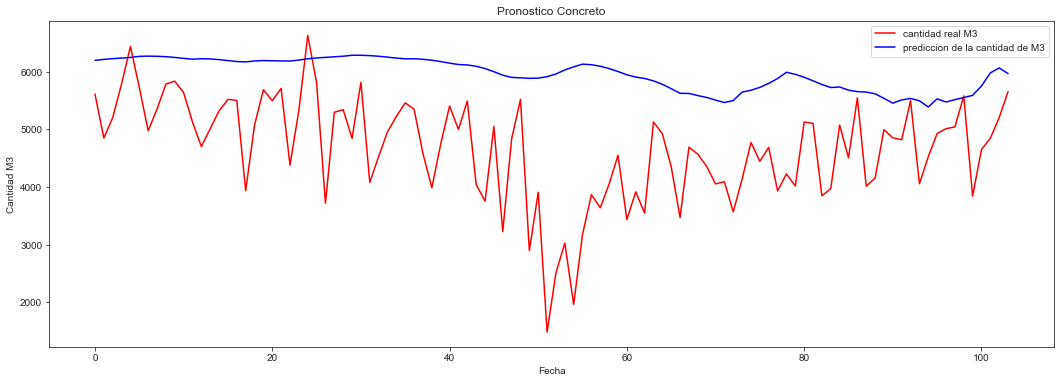

In [100]:
plt.figure(figsize=(18,6))
plt.plot(test_set[: , 0], color = 'red', label = 'cantidad real M3')
plt.plot(prediction[:, 0:1], color = 'blue', label = 'prediccion de la cantidad de M3')
plt.title('Pronostico Concreto')
plt.xlabel('Fecha')
plt.ylabel('Cantidad M3')
plt.legend()
plt.show()

In [66]:
df_real_prediccion = pd.DataFrame({'Real':test_set[: , 0], 'Forecast':prediction[:, 0]})
df_real_prediccion['APE'] = ((df_real_prediccion['Real'] - df_real_prediccion['Forecast']).abs())/df_real_prediccion['Real'].fillna(0) 
df_real_prediccion['APE'].mean()

0.08330315082203299

In [128]:
#guardo la RNR para futuros usos
regressor.save("../datos/" + pais +"/" + pais + ".h5")

<h2> Ejecución de la predicción <h2/>

In [8]:
#cargo el regresor previamente entrenado
regressor = load_model('../datos/' + pais + '/'+ pais +'.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [101]:
#Organizo la informacion del calendario del forecast
fecha_inicio_forecast = '2021-07-10'
fecha_fin_forecast = '2021-08-31'

dataset_pred = pd.read_excel("../datos/" + pais + "/" + pais + " aux.xlsx")
dataset_pred['FechaEntrega'] = pd.to_datetime(dataset_pred['FechaEntrega'])
dataset_pred = dataset_pred[ (dataset_pred['FechaEntrega'] >= fecha_inicio_forecast) & (dataset_pred['FechaEntrega'] <= fecha_fin_forecast)]
auxPrediction = dataset_pred
auxPrediction = auxPrediction.reset_index()
dataset_pred = dataset_pred[['Dia_Semana', 'Dia_Semana', 'Mes', 'Semana_relativa', 'Semanas_mes', 'Año']]
#tomo unicamente el array que me interasa del dataframe 
predict_set = dataset_pred.iloc[:, 0:7].values
# load the scaler
scaler = load(open("../datos/" + pais + "/" + pais + '.pkl', 'rb'))
predict_set_scaled = scaler.transform(predict_set)

dataset_test = dataset[ dataset['Fecha'] < fecha_inicio_forecast ]
test_set  = dataset_test.iloc[:, 2:8].values

# Escalado de características
test_set_scaled = sc.transform(test_set)

#los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
inputs = test_set_scaled[len(test_set_scaled) - timesteps: ]

In [102]:
for j in range (0, predict_set_scaled.shape[0] ):
    X_test = []
    X_test_material = []
    X_test_DiaSemana = []
    X_test_SemanaRelativa = []
    X_test_SemanaMes = []
    X_test_Mes = []
    X_test_Year = []

    for i in range(timesteps, inputs.shape[0]+1 ):

        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_test_DiaSemana.append( inputs[i-timesteps:i, 1])

        #columna 2 -> Mes
        X_test_Mes.append( inputs[i-timesteps:i, 2])        

        #columna 3 -> SemanaRelativa
        X_test_SemanaRelativa.append( inputs[i-timesteps:i, 3])

        #columna 4 -> SemanaMes
        X_test_SemanaMes.append( inputs[i-timesteps:i, 4])

        #columna 5 -> Year
        X_test_Year.append( inputs[i-timesteps:i, 5])


    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    X_test_DiaSemana =  np.array(X_test_DiaSemana )
    X_test_SemanaRelativa = np.array( X_test_SemanaRelativa)
    X_test_SemanaMes = np.array(X_test_SemanaMes )
    X_test_Mes = np.array(X_test_Mes )
    X_test_Year = np.array( X_test_Year)

    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
    X_test_SemanaRelativa = np.reshape(X_test_SemanaRelativa, (X_test_SemanaRelativa.shape[0], X_test_SemanaRelativa.shape[1], 1 ))
    X_test_SemanaMes = np.reshape(X_test_SemanaMes, (X_test_SemanaMes.shape[0], X_test_SemanaMes.shape[1], 1 ))
    X_test_Mes = np.reshape(X_test_Mes, (X_test_Mes.shape[0], X_test_Mes.shape[1], 1 ))
    X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))

    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test = np.append(X_test_material, (X_test_DiaSemana), axis = 2 )
    X_test = np.append(X_test, (X_test_Mes), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaRelativa), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaMes), axis = 2 )
    X_test = np.append(X_test, (X_test_Year), axis = 2 )

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (predict_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = test_set_scaled[len(test_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )

prediction = sc.inverse_transform(prediction)

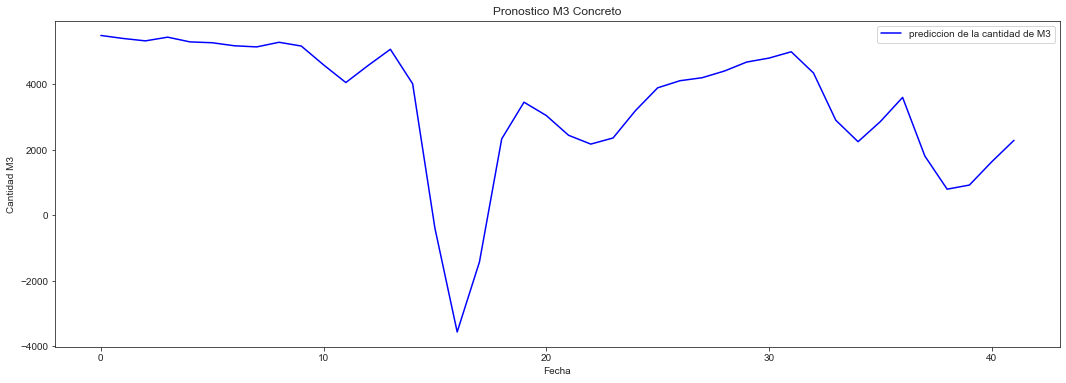

In [103]:
plt.figure(figsize=(18,6))
plt.plot(prediction[:, 0:1], color = 'blue', label = 'prediccion de la cantidad de M3')
plt.title('Pronostico M3 Concreto')
plt.xlabel('Fecha')
plt.ylabel('Cantidad M3')
plt.legend()
plt.show()

In [104]:
df_result = pd.DataFrame({'Forecast':prediction[:, 0]})
df_result = pd.concat([auxPrediction, df_result], axis=1)
df_result.groupby('Mes')['Forecast'].sum()

Mes
7    69769.192369
8    73298.909793
Name: Forecast, dtype: float64

In [105]:
output= BytesIO()
writer = pd.ExcelWriter(output, engine='xlsxwriter')
writer = pd.ExcelWriter("../datos/" + pais +"/results_" + pais + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S") + ".xlsx", engine="xlsxwriter")
df_result.to_excel(writer)
writer.save()